In [32]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import ticker
from matplotlib import colors
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import pandas as pd
from io import StringIO
import csv

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Plot from thesis

In [46]:
lw, ms, fs_numb, fs_str = 6, 12, 25, 30
def thesis_fig():
    
    real_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/realistic/real_bathy_for_agrif.nc')
    coords_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/NEMO_files/coords_for_agrif.nc')
    y,x = slice(1,-1,None), slice(1,-1,None)
    
    # --------------------------------------------------------

    nav_lat = coords_file['nav_lat'][y, x]
    nav_lon = coords_file['nav_lon'][y, x]
    real = real_file['Bathymetry'][y, x]

    coords_ctrl = [-139.93484321666668, 70.55863003333333]
    coords_eval = [-139.60871666666668, 70.70343333333334]
    lat_nut, lon_nut, time_nut = np.loadtxt('../thesis/files/nutrient_info.out', delimiter=",")
    salt_nut, PO4, NO3 = np.loadtxt('../thesis/files/nutrient_prof.out', delimiter=",")
    
    # --------------------------------------------------------

    fig, axm = plt.subplots(1,1,figsize=(15,10))

    axm.tick_params(direction='in', length=4, color='k', labelsize=fs_numb)
    axm.xaxis.set_ticks_position('none') 
    axm.yaxis.set_ticks_position('none')
    for axis in ['top','bottom','left','right']:
        axm.spines[axis].set_linewidth(2)

    axm.contour(nav_lon, nav_lat, real, levels = np.arange(0, 500, 20), colors='k', linestyle='-', alpha=0.5)
    w=1/math.cos(math.radians(70.0))
    axm.set_aspect(w)
    axm.set_xlim([-141.5, -136.2])
    axm.set_ylim([68.9, 71.1])
    s1 = axm.scatter(coords_ctrl[0], coords_ctrl[1], c='steelblue', s=300, label='control stratification')
    s2 = axm.scatter(coords_eval[0], coords_eval[1], c='mediumseagreen', s=300, label='evaluation stratification')
    s3 = axm.scatter(-1*lon_nut, lat_nut, c='orangered', s=300, label='nitrate concentration')

    axm.text(coords_ctrl[0]+1.0, coords_ctrl[1]-0.05, 'control', ha='center', fontsize=fs_numb*0.9)
    axm.text(coords_eval[0]+1.4, coords_eval[1]-0.05, 'evaluation', ha='center', fontsize=fs_numb*0.9)
    axm.text(-140.5, 70-0.12, 'nitrate', ha='center', fontsize=fs_numb*0.9)
    axm.text(-138.5, 70-0.12, 'nitrate', ha='center', fontsize=fs_numb*0.9)
    axm.text(-139.5, 71-0.12, 'nitrate', ha='center', fontsize=fs_numb*0.9)

    axm.yaxis.set_ticks([69, 70, 71])
    axm.xaxis.set_ticks([-137, -140])
    axm.set_yticklabels([str(x)+'$\degree$N' for x in axm.get_yticks().tolist()])
    axm.set_xticklabels([str(abs(x))+'$\degree$W' for x in axm.get_xticks().tolist()])
    axm.set_xlabel('Longitude', fontsize=fs_str, labelpad=5)
    axm.set_ylabel('Latitude', fontsize=fs_str, labelpad=5)

    fig.patch.set_facecolor('white')

    fig.tight_layout(w_pad=2.0, h_pad=1)
    
    return fig, axm

## Data files for both Mackenzie River and historic runs

In [33]:
filenames = ['CTD_1974.csv', 'CTD_1979.csv', 'CTD_1984.csv', 'CTD_1985.csv', 'CTD_2012.csv']

In [69]:
attributes = np.full([len(filenames), 5], np.nan)

for filename, n in zip(filenames, np.arange(len(filenames))):

    df_attrib = pd.read_csv(filename, error_bad_lines=False, skiprows=[0], header=None, warn_bad_lines=False)
    latitude = df_attrib.iloc[3][2]
    longitude = df_attrib.iloc[4][2]
    year = int(df_attrib.iloc[5][2])
    month = int(df_attrib.iloc[6][2])

    print(filename, year, month, latitude, longitude)
   
    attributes[n, 0] = year
    attributes[n, 1] = month
    attributes[n, 2] = latitude
    attributes[n, 3] = longitude
    
attributes

CTD_1974.csv 1974 9         70.0917       -139.1333
CTD_1979.csv 1979 11         70.4167       -139.0000
CTD_1984.csv 1984 9          70.988         -139.07
CTD_1985.csv 1985 8          70.628        -139.933
CTD_2012.csv 2012 8         69.8762       -137.2425


array([[1974.    ,    9.    ,   70.0917, -139.1333,       nan],
       [1979.    ,   11.    ,   70.4167, -139.    ,       nan],
       [1984.    ,    9.    ,   70.988 , -139.07  ,       nan],
       [1985.    ,    8.    ,   70.628 , -139.933 ,       nan],
       [2012.    ,    8.    ,   69.8762, -137.2425,       nan]])

195.9
401.39
245.7
986.9
42.56


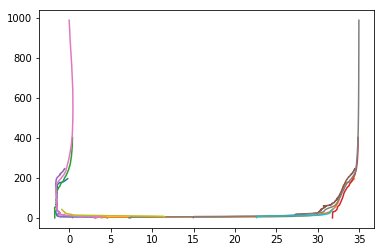

In [70]:
for filename, n in zip(filenames, np.arange(len(filenames))):
    
    df_data = pd.read_csv(filename, skiprows=np.arange(23), header=None, warn_bad_lines=False)
    
    depths = df_data[1]
    temperature = df_data[4]
    salinity = df_data[7]

    plt.plot(temperature, depths)
    plt.plot(salinity, depths)
    
    len_dep = len(depths)
    max_dep = depths[len_dep-2]
    print(max_dep)
    
    attributes[n, 4] = max_dep

# Locations

70.0917 -139.1333
70.4167 -139.0
70.988 -139.07
70.628 -139.933
69.8762 -137.2425


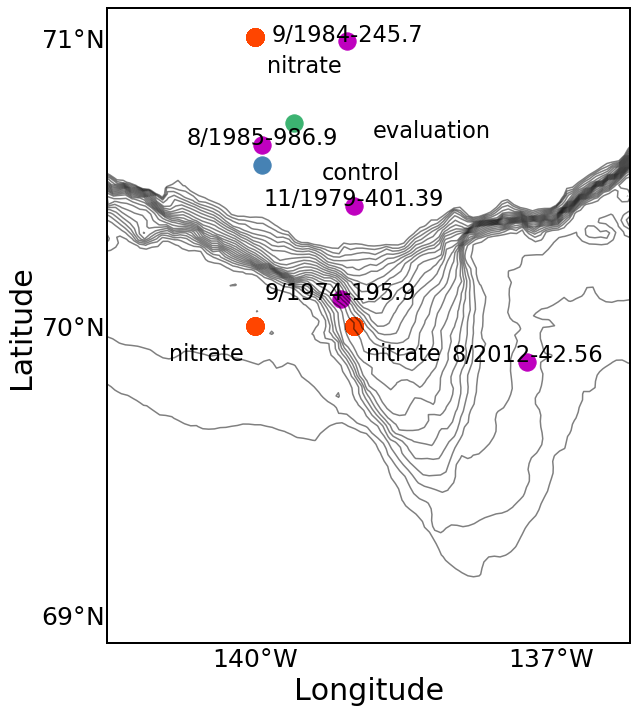

In [71]:
fig, axm = thesis_fig()
for filename, n in zip(filenames, np.arange(len(filenames))):
    print(attributes[n, 2], attributes[n, 3])
    axm.scatter(attributes[n, 3], attributes[n, 2], c='m', s=300)
    label_new = str(int(attributes[n, 1]))+'/'+str(int(attributes[n, 0]))+'-'+str(attributes[n, 4])
    axm.text(attributes[n, 3], attributes[n, 2], label_new, ha='center', fontsize=fs_numb*0.9)